## Dependencies

In [24]:
!pip install numpy
!pip install pandas
!pip install seaborn
!pip install matplotlib
!pip install scikit-learn


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [73]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support, classification_report
import pickle

## Load  Data

In [69]:
TRAIN_CSV = '../Dataset/train_cleaned.csv'
TEST_CSV = '../Dataset/test_cleaned.csv'

In [27]:
train_df = pd.read_csv(TRAIN_CSV)
train_df.head()

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,...,Gender_Female,Gender_Male,Customer Type_Loyal Customer,Customer Type_disloyal Customer,Type of Travel_Business travel,Type of Travel_Personal Travel,Class_Business,Class_Eco,Class_Eco Plus,satisfaction
0,13,460,3,4,3,1,5,3,5,5,...,False,True,True,False,False,True,False,False,True,False
1,25,235,3,2,3,3,1,3,1,1,...,False,True,False,True,True,False,True,False,False,False
2,26,1142,2,2,2,2,5,5,5,5,...,True,False,True,False,True,False,True,False,False,True
3,25,562,2,5,5,5,2,2,2,2,...,True,False,True,False,True,False,True,False,False,False
4,61,214,3,3,3,3,4,5,5,3,...,False,True,True,False,True,False,True,False,False,True


## Model Training

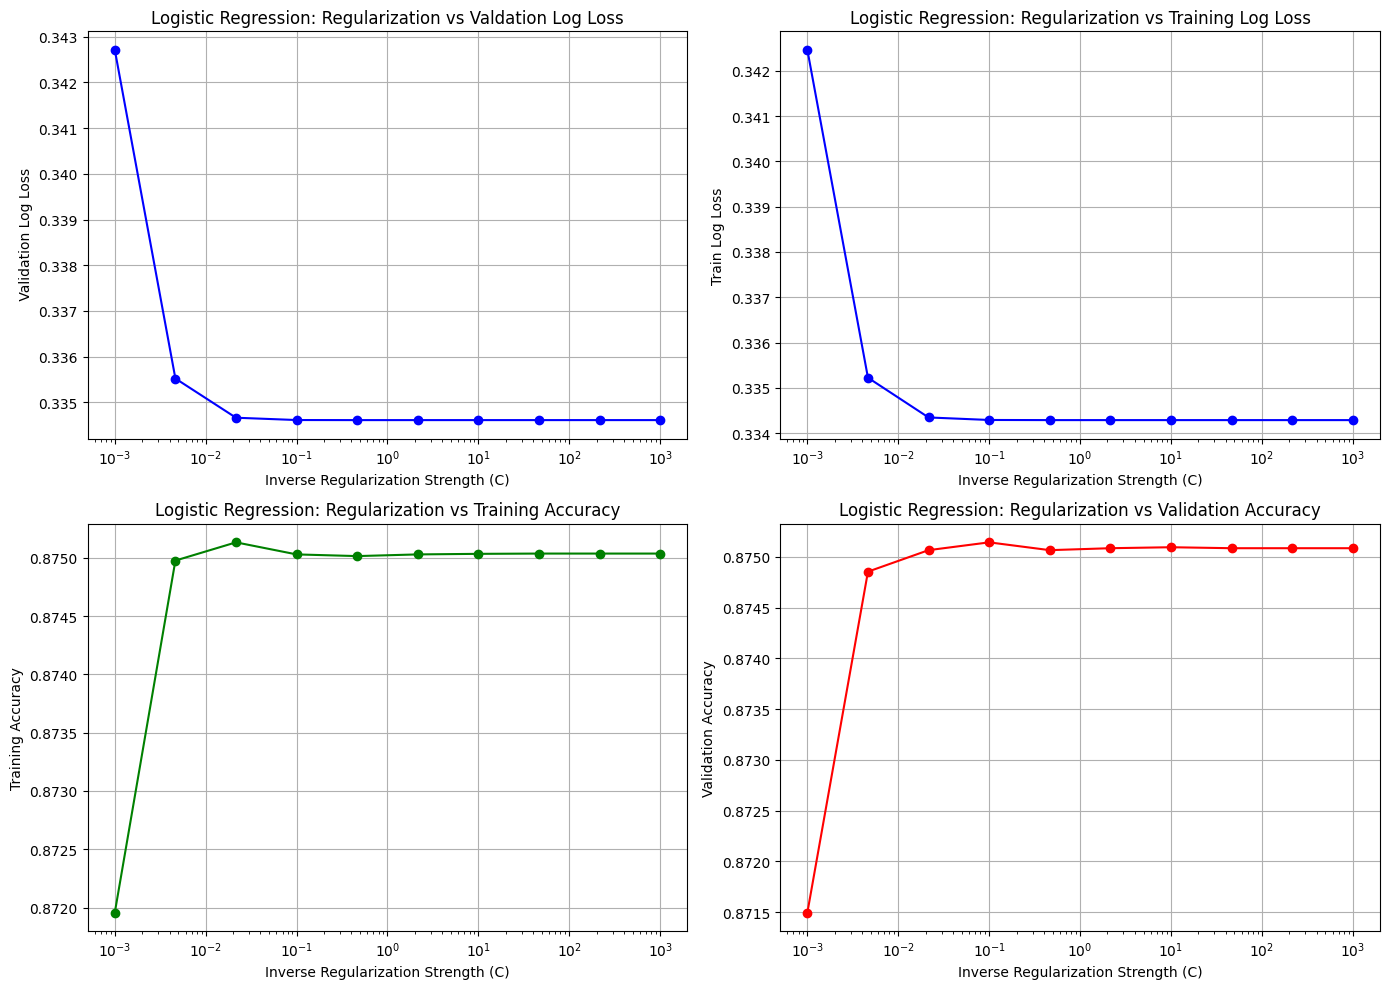

In [44]:
X = train_df.drop(columns=['satisfaction'])
y = train_df['satisfaction']
num_cols = ['Age', 'Flight Distance', 'Departure Delay in Minutes']

#! scale numerical features 
ct = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols)
    ],
    remainder='passthrough'  
)
X = ct.fit_transform(X)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
C_values = np.logspace(-3, 3, 10)
mean_losses = []
mean_train_accuracies = []
mean_val_accuracies = []
mean_train_losses = []
for C in C_values:
    model = LogisticRegression(C=C, penalty='l2', solver='newton-cholesky', max_iter=10000)
    
    # Negative log loss (lower is better)
    scores = cross_validate(model, X, y, cv=kf, 
                            scoring=['accuracy', 'neg_log_loss'], 
                            return_train_score=True)
    loss = -scores['test_neg_log_loss'].mean()
    train_loss = -scores['train_neg_log_loss'].mean()
    mean_losses.append(loss)
    
    train_accuracy = scores['train_accuracy'].mean()
    val_accuracy = scores['test_accuracy'].mean()
    mean_train_accuracies.append(train_accuracy)
    mean_val_accuracies.append(val_accuracy)
    mean_train_losses.append(train_loss)
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

axs[0, 0].plot(C_values, mean_losses, marker='o', color='blue')
axs[0, 0].set_xscale('log')
axs[0, 0].set_xlabel('Inverse Regularization Strength (C)')
axs[0, 0].set_ylabel(' Validation Log Loss')
axs[0, 0].set_title('Logistic Regression: Regularization vs Valdation Log Loss')
axs[0, 0].grid(True)

axs[0, 1].plot(C_values, mean_train_losses, marker='o', color='blue')
axs[0, 1].set_xscale('log')
axs[0, 1].set_xlabel('Inverse Regularization Strength (C)')
axs[0, 1].set_ylabel('Train Log Loss')
axs[0, 1].set_title('Logistic Regression: Regularization vs Training Log Loss')
axs[0, 1].grid(True)

axs[1, 0].plot(C_values, mean_train_accuracies, marker='o', color='green')
axs[1, 0].set_xscale('log')
axs[1, 0].set_xlabel('Inverse Regularization Strength (C)')
axs[1, 0].set_ylabel('Training Accuracy')
axs[1, 0].set_title('Logistic Regression: Regularization vs Training Accuracy')
axs[1, 0].grid(True)

axs[1, 1].plot(C_values, mean_val_accuracies, marker='o', color='red')
axs[1, 1].set_xscale('log')
axs[1, 1].set_xlabel('Inverse Regularization Strength (C)')
axs[1, 1].set_ylabel('Validation Accuracy')
axs[1, 1].set_title('Logistic Regression: Regularization vs Validation Accuracy')
axs[1, 1].grid(True)
plt.tight_layout()
plt.show()

In [45]:
best_C = C_values[np.argmax(mean_val_accuracies)]
print(f'Best C value: {best_C}')


Best C value: 0.1


In [64]:
model = LogisticRegression(C=best_C, penalty='l2', solver='newton-cholesky', max_iter=10000)
model.fit(X, y)

LogisticRegression(C=0.1, max_iter=10000, solver='newton-cholesky')

## Training Metrics

In [65]:
y_pred = model.predict(X)
accuracy = accuracy_score(y, y_pred)


print("\nClassification Report:\n")
print(classification_report(y, y_pred))


Classification Report:

              precision    recall  f1-score   support

       False       0.88      0.90      0.89     58878
        True       0.87      0.84      0.85     45024

    accuracy                           0.87    103902
   macro avg       0.87      0.87      0.87    103902
weighted avg       0.87      0.87      0.87    103902



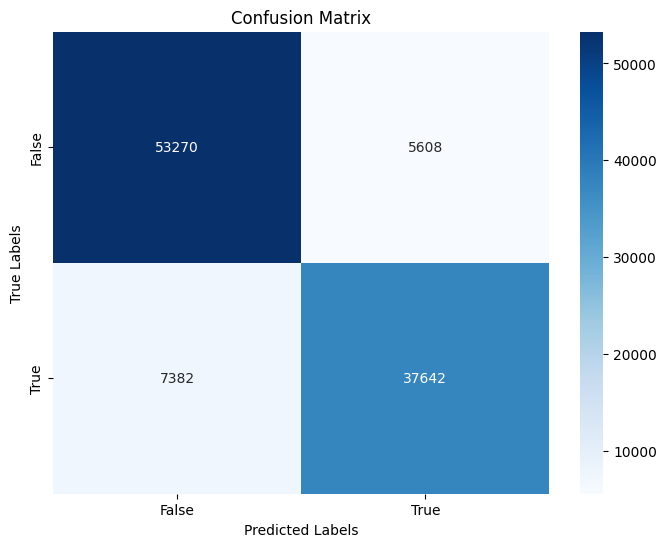

In [66]:
cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Test Metrics

In [70]:
test_df = pd.read_csv(TEST_CSV)
X_test = test_df.drop(columns=['satisfaction'])
y_test = test_df['satisfaction']
X_test = ct.fit_transform(X_test)

In [71]:
y_pred_test = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_test)


print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_test))


Classification Report:

              precision    recall  f1-score   support

       False       0.87      0.90      0.89     14573
        True       0.87      0.83      0.85     11403

    accuracy                           0.87     25976
   macro avg       0.87      0.87      0.87     25976
weighted avg       0.87      0.87      0.87     25976



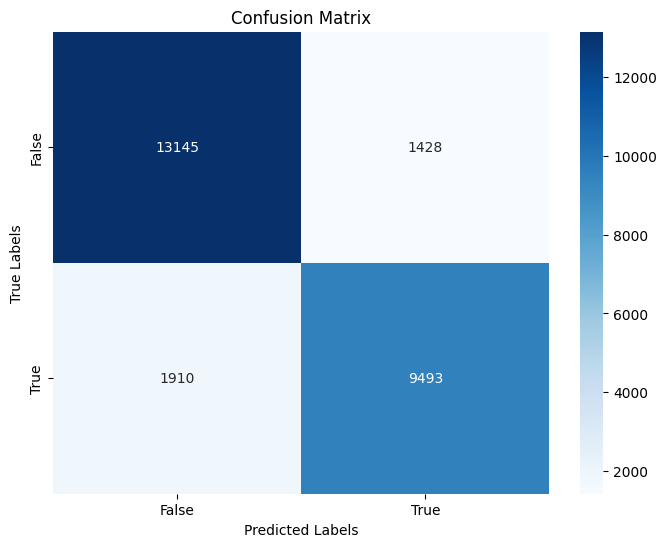

In [72]:
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [75]:
pickle.dump(model, open('../Models/logistic_model.pkl', 'wb'))